# Multivariate quantiles and long horizon forecasting with N-HiTS

This demo outines the application of the NHITS method using the PyTorch Forecasting. [PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) is a package that provides convenient implementations of several leading deep learning-based forecasting models, namely [Temporal Fusion Transformers](https://arxiv.org/pdf/1912.09363.pdf), [N-BEATS](http://arxiv.org/abs/1905.10437), and [DeepAR](https://www.sciencedirect.com/science/article/pii/S0169207019301888). PyTorch Forecasting is built using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/), making it easier to train in multi-GPU compute environments, out-of-the-box. This demo was adapted from a tutorial in the [PyTorch Forecasting Documentation](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/nhits.html). 

## Package Imports and Global Variables

**Note for Colab users:** Run the following cell to install PyTorch Forecasting. After installation completes, you will likely need to restart the Colab runtime. If this is the case, a button `RESTART RUNTIME` will appear at the bottom of the next cell's output.

In [2]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting[mqf2]
    !pip install pytorch lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 44.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 KB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/5

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MQF2DistributionLoss, QuantileLoss

## Load Data

PyTorch forecasting provides the ability to generate a synthetic dataset using the `generate_ar_data` function. The generated data consists of 100 time series each with 400 time steps. Each time series is generated with the specified seasonality, trend and level along with a noise term. This is the time series we will be working with throughout the demo. 

In [5]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,date
0,0,0,-0.000000,2020-01-01
1,0,1,-0.046501,2020-01-02
2,0,2,-0.097796,2020-01-03
3,0,3,-0.144397,2020-01-04
4,0,4,-0.177954,2020-01-05


## Data Formatting

Now that we have generated the dataset, we can transform it in a format that PyTorch Forecasting Expect. To this end, the dataset should be stored in a [TimeSeriesDataSet](https://pytorch-forecasting.readthedocs.io/en/latest/data.html) objects. Building a TimeSeriesDataSet begins with a Pandas DataFrame that we need to add certain custom columns. 

PyTorch Forecasting models can accomodate datasets consisting of multiple, coincident time series in several ways. As per the [documentation](https://pytorch-forecasting.readthedocs.io/en/latest/data.html), a combination of `group_id` and `time_idx` identify a sample in the data, and that *if we have only one time series, to set* `group_id` *to a constant.* `time_idx` is an *integer column denoting the time index*. This, as opposed to the `date` column, is used to determine the temporal sequence of samples. 

Once the dataset in generated, it can be split into train and validation with the help of the `TimeSeriesDataSet.from_dataset` method. The `min_prediction_idx` argument of this method allows us to avoid having crossover between the train and validation set. 

In [6]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Model

### NHITS Overview

<p align="center">
<img width="750" alt="NHITS Architecture" src="https://user-images.githubusercontent.com/34798787/156445832-58e5e082-5003-4859-92f6-cb029ddbd378.png">
</p>

NHITS is a popular deep learning based approach to time series forecasting. In particualr, NHITS adapts the NBEATS architecture to perform long sequence time series forecasting (LSTF); a task where the length of the input and output sequence are large. NHITS learns a global model from historical data of one or more time series. Thus, although the input and output space is univariate, NHITS can be used to jointly model a set of related time series. The architecture consists of deep stacks of fully connected layers connected with forward and backward residual links. The forwad links aggregate partial forecast to yield final forecast. Alternatively, backward links subtract out input signal corresponding to already predicted partial forecast from input prior to being passed to the next stack. NHITS builds on NBEATS by enhancing its input decomposition via multi-rate data sampling and its output synthesizer via multi-scale interpolation. This increases both the accuracy and  computational efficiency of the approach in the LSTF setting. 

Some of the additonal benefits of NHITS include:

- **Interpretability**: Allows for hierarchical decomposition of a forecasts into trend and seasonal components which enhances interpretability.
- **Ensembling**: Ensembles models fit with different loss functions and time horizons. The final prediction is mean of models in ensemble.
- **Efficient**: Avoids the use of recurrent structute and predicts entire ouput sequence in single forward pass.
- **Covariates**: NHITS allows for the inclusion of covariates compared to NBEATS which does not. 



### Model Definition
Using the Pytorch Forecasting package, an NHITS model can easily be initialized using the `NHiTS.from_dataset` method. This method constructs a NHITS model using the characteristics of the TimeSeriesDataset that it is operating on. The arguments of the method include: 
- `dataset`: (TimeSeriesDataset) time series dataset
- `hidden_size`: (int) – size of hidden layers and can range from 8 to 1024 - use 32-128 if no covariates are employed. Defaults to 512.
- `learning_rate`: (float) The learning rate of the optimization procedure. 
- `weight_decay`: (float) The weight decay that is applied to the model parameters. 

PyTorch Forecasting is flexible enough to use NHiTS with different loss functions, enabling not only point forecasts but also probabilistic ones. Here, we will demonstrate not only a typical quantile regression but a multivariate quantile regression with MQF2DistributionLoss which allows calculation sampling consistent paths along a prediction horizon. 

For additional details in regards to the `NHiTS` class, consult the  [PyTorch Forecasting Documentation](https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.nhits.NHiTS.html#pytorch_forecasting.models.nhits.NHiTS).

In [7]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=1, gradient_clip_val=1.0)
net = NHiTS.from_dataset(
    training,
    learning_rate=0.09,
    weight_decay=1e-2,
    hidden_size=64,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training and Validation
We first define a pytorch lighting trainer which encapsulates the training process and allows us to easily implement a training and validation loop with the specified parameters. The arguments to the trainer include: 
- `max_epochs`: (Optional[int]) – Stop training once this number of epochs is reached. 
- `gpus`: (Union[int, None]) Number of GPUs to train on (int). Default: None.
- `callbacks`: (Union[List[Callback], Callback, None]) – Add a callback or list of callbacks.

Subsequently, we can use the `fit` method of the trainer with the `net`, `train_dataloader` and `val_dataloader` to perform the training and validation loop. 

For more information regarding the `pl.Trainer` class, consult the [PyTorch Lightning documentation](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.html#pytorch_lightning.trainer.trainer.Trainer.validate).

In [8]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=3, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=25,
    gpus=1,
    enable_model_summary=True,
    callbacks=[early_stop_callback],
    enable_checkpointing=True,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 5.1 K 
1 | logging_metrics | ModuleList           | 0     
2 | embeddings      | MultiEmbedding       | 0     
3 | model           | NHiTS                | 35.7 K
---------------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Visualize Forecasts

### Quantile Forecasts

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [10]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

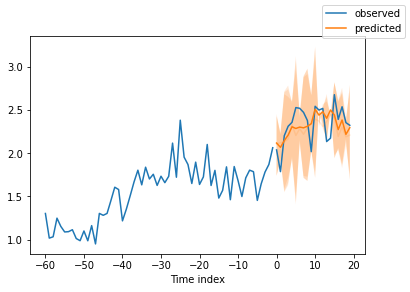

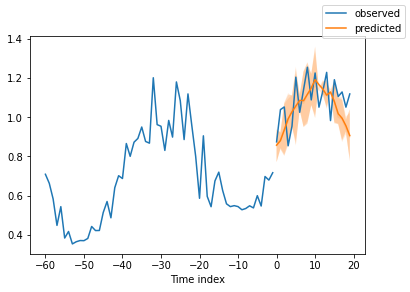

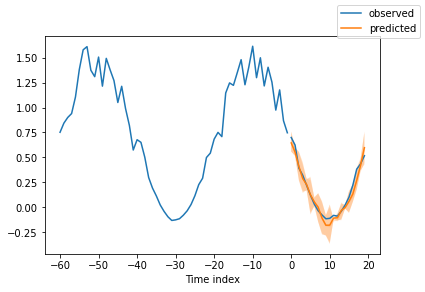

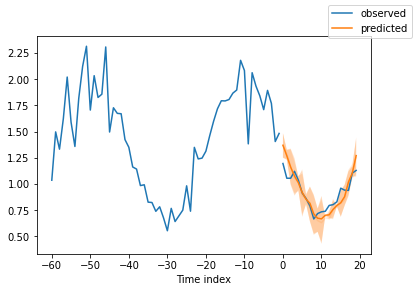

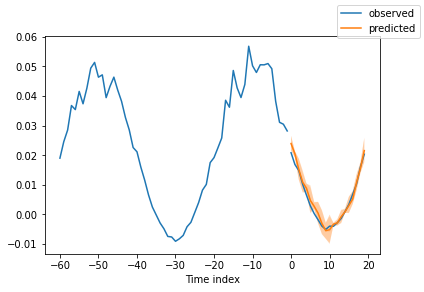

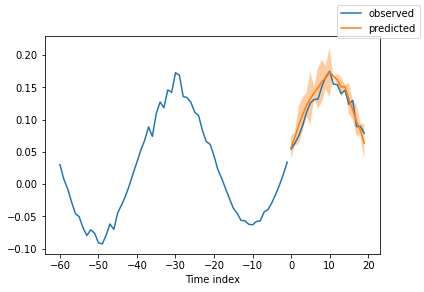

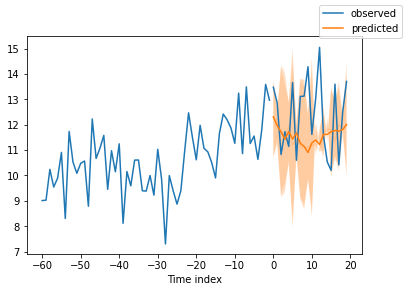

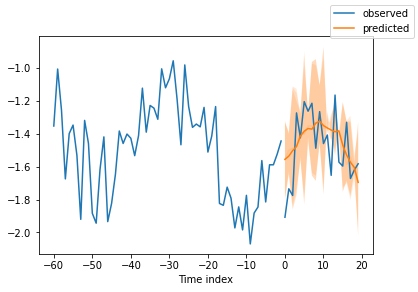

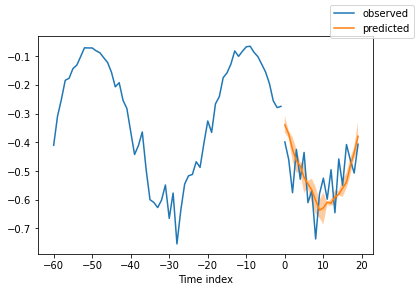

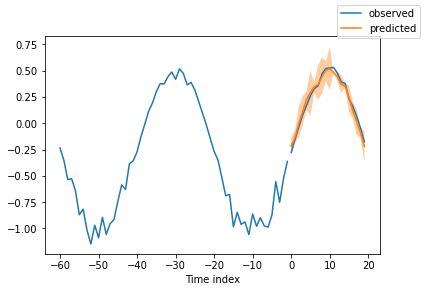

In [11]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx);

### Interpretable Forecasts

We can ask PyTorch Forecasting to decompose the prediction into blocks which focus on a different frequency spectrum, e.g. seasonality and trend with `pytorch_forecasting.models.nhits.NHiTS.plot_interpretation`. This is a special feature of the `pytorch_forecasting.models.nhits.NHiTS` model and only possible because of its unique architecture. The results show that there seem to be many ways to explain the data and the algorithm does not always chooses the one making intuitive sense. This is partially down to the small number of time series we trained on (100). But it is also due because our forecasting period does not cover multiple seasonalities.

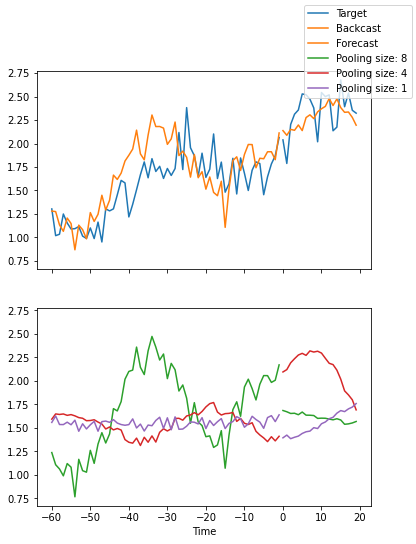

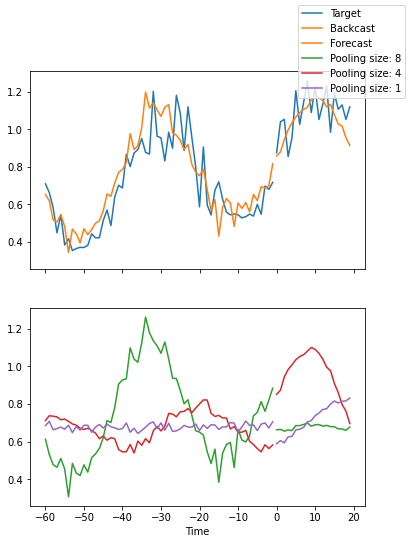

In [12]:
for idx in range(2):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx);

### Sampling Forecasts

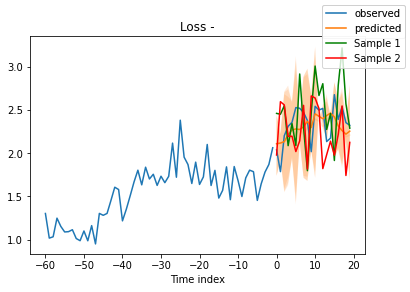

In [13]:
# sample 500 paths
samples = best_model.loss.sample(raw_predictions["prediction"][[0]], n_samples=500, )[0]

# plot prediction
fig = best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True, )
ax = fig.get_axes()[0]
# plot first two sampled paths
ax.plot(samples[:, 0], color="g", label="Sample 1", )
ax.plot(samples[:, 1], color="r", label="Sample 2")
fig.legend();

As expected, the variance of predictions is smaller within each sample than accross all samples.

In [14]:
print(f"Var(all samples) = {samples.var():.4f}")
print(f"Mean(Var(sample)) = {samples.var(0).mean():.4f}")

Var(all samples) = 0.1305
Mean(Var(sample)) = 0.1192


We can now do something new and plot the distribution of sums of forecasts over the entire prediction range.

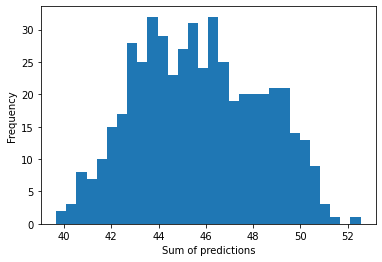

In [15]:
plt.hist(samples.sum(0).numpy(), bins=30)
plt.xlabel("Sum of predictions")
plt.ylabel("Frequency");

## Quantitative Results

In order to quantitatively assess the performance of the model we can use the [Symmetric Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error). Pytorch Forecasting includes this and other metrics in the `pytorch_forecasting.metrics` module. As a baseline, we can also define a naive forecasting model, `pytorch_forecasting.Baseline`, that produces forecasts by repeating the last known value in the time series. Unsurprisingly, the NHITS model is able to outperform this naive baseline.

In [16]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
predictions = best_model.predict(val_dataloader)
baseline_smape = SMAPE()(baseline_predictions, actuals)
nhits_smape = SMAPE()(predictions, actuals)

print(nhits_smape.item(), baseline_smape.item())

0.13167539238929749 0.5462026596069336
